# Introduction
Understand the basics of neural networks from scratch.
Know how to handle image data
After implementing a simple neural network from scratch, we will train and validate it.

In [239]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MINIST Dataset

In [240]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [241]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [242]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## Data Visualization

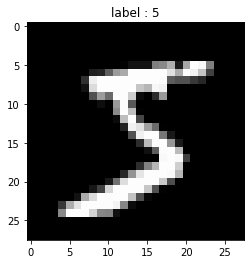

In [243]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

### Weird negative case that is not handled!

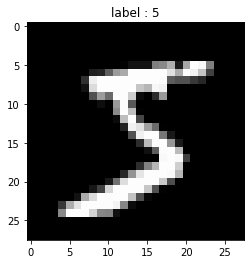

In [244]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # Convert to float type
image -= 105.35 # Intentionally try to create a negative decimal value
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
# print(image) # Check the value

### Fix with auto scale to 0-255

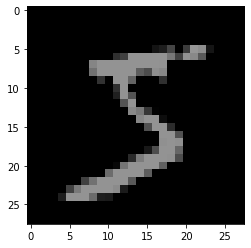

In [245]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

## Preprocessing


In [246]:
#scaling
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [247]:
#one hot encode for multiclass labels!
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
print(y_test_one_hot.shape) #(10000, 10)

(60000,)
(60000, 10)
float64
(10000, 10)


In [248]:
#validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
y_train[0]

(48000, 784)
(12000, 784)


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# Mini Batch

In [249]:
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [250]:
#test minibatch
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
# print(len(get_mini_batch)) # 2400
# print(get_mini_batch[5]) # You can get the 5th mini batch
for mini_X_train, mini_y_train in get_mini_batch:
    # You can use a mini batch in this for statement
    print('Train Batch shape: ', mini_X_train.shape, mini_y_train.shape)
    print(mini_X_train)
    print(mini_y_train)
    break
    pass

Train Batch shape:  (20, 784) (20, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Problem 1
Creating a code to determine the initial weight value

In [251]:
#sample code
def sample():
    n_features = 784
    n_nodes1 = 400
    sigma = 0.01 # Standard deviation of Gaussian distribution
    W1 = sigma * np.random.randn(n_features, n_nodes1)
    print('Weights: ', W1.shape)
    print('W1: ', W1[:5])
sample()

Weights:  (784, 400)
W1:  [[ 0.00792546 -0.00145092 -0.01287133 ... -0.00245453 -0.03460641
   0.00758269]
 [-0.00137276  0.00278289  0.00932826 ... -0.01495581  0.00968798
   0.0101332 ]
 [-0.00746748  0.00905245  0.0006038  ...  0.01249155 -0.00529285
   0.00730488]
 [-0.00926189  0.01516508  0.02151677 ...  0.01362972 -0.00037262
   0.01172848]
 [ 0.00987992 -0.00489221 -0.02501196 ... -0.00026348  0.00225029
   0.0098098 ]]


# Problem 2
Implementation of forward propagation

In [252]:
batch_size = 20 # batch size 
n_features = 784 # number of features 
n_nodes1 = 400 # number of first layer nodes 
n_nodes2 = 200 # number of second layer nodes 
n_output = 10 # number of output classes (number of nodes in the 3rd layer)

In [253]:
#activation functions
def sigmoid(X):
    return 1 / (1 + np.exp(-X))
def hyper_tan(X):
    return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))    

In [254]:
#soft max
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X), axis = 1).reshape(-1,1)

**We'll do calculations on one batch**

In [255]:
batch_size = 20 # batch size 
n_features = 784 # number of features 
n_nodes1 = 400 # number of first layer nodes 
n_nodes2 = 200 # number of second layer nodes 
n_output = 10 # number of output classes (number of nodes in the 3rd layer)
X = get_mini_batch[0][0]
Y = get_mini_batch[0][1]

In [256]:
#weight, bias
sigma = 0.01 # Standard deviation of Gaussian distribution
W1 = sigma * np.random.randn(n_features,n_nodes1)
bias1 = sigma * np.random.randn(n_nodes1).reshape(1,-1)
activation = sigmoid
print('X shape: ', X.shape)
print('W1: ',W1.shape, 'bisas1: ', bias1.shape)
# first layer
A1 = X@W1 + bias1
Z1= activation(A1)
print('Z1 shape: ', Z1.shape)
# second layer
W2 = sigma * np.random.randn(n_nodes1,n_nodes2)
bias2 = sigma * np.random.randn(n_nodes2).reshape(1,-1)
A2 = Z1@W2 + bias2
Z2 = activation(A2)
print('W2: ',W2.shape, 'bisas2: ', bias2.shape)
print('Z2 shape: ', Z2.shape)
#last (third) layer
W3 = sigma * np.random.randn(n_nodes2,n_output)
bias3 = sigma * np.random.randn(n_output).reshape(1,-1)
A3 = Z2@W3 + bias3
Z3 = softmax(A3)
print('W3: ',W3.shape, 'bisas3: ', bias3.shape)
print('Z3 shape: ', Z3.shape)

X shape:  (20, 784)
W1:  (784, 400) bisas1:  (1, 400)
Z1 shape:  (20, 400)
W2:  (400, 200) bisas2:  (1, 200)
Z2 shape:  (20, 200)
W3:  (200, 10) bisas3:  (1, 10)
Z3 shape:  (20, 10)


# Problem 3
Implementation of cross entropy error

In [257]:
def cross_entropy_error(Z,y):
    print('Z: ',Z[0])
    print('Y: ', Y[0])
    return (np.log(Z) * y).sum() / (- len(Z))
print(Z3.shape, Y.shape)
print('Cross Entro: ', cross_entropy_error(Z3, Y))

(20, 10) (20, 10)
Z:  [0.09794321 0.09483272 0.09967666 0.10881523 0.11919712 0.08142486
 0.10240371 0.09915095 0.10739893 0.08915659]
Y:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cross Entro:  2.276759763778918


# Problem 4
Implementation of backpropagation

### Layer 3 Gradient

In [258]:
nb = batch_size #batch size (tuple count)

grad_L_A3 = 1/nb * (Z3 - Y)
print('Gradient L/A3: ', grad_L_A3.shape)
grad_L_B3 = grad_L_A3.sum(axis = 0)
print('Gradient L/B3: ', grad_L_B3.shape)
grad_L_W3 = Z2.T @ grad_L_A3
print('Gradient L/W3: ', grad_L_W3.shape)
grad_L_Z2 = grad_L_A3 @ W3.T
print('Gradient L/Z2: ', grad_L_Z2.shape)


Gradient L/A3:  (20, 10)
Gradient L/B3:  (10,)
Gradient L/W3:  (200, 10)
Gradient L/Z2:  (20, 200)


### Layer 2 Gradient

In [259]:
grad_L_A2 = grad_L_Z2 * (1 - np.tanh(A2)** 2)
print('Gradient L/A2: ', grad_L_A2.shape)
grad_L_B2 = grad_L_A2.sum(axis = 0)
print('Gradient L/B2: ', grad_L_B2.shape)
grad_L_W2 = Z1.T @ grad_L_A2
print('Gradient L/W2: ', grad_L_W2.shape)
grad_L_Z1 = grad_L_A2 @ W2.T
print('Gradient L/Z1: ', grad_L_Z1.shape)

Gradient L/A2:  (20, 200)
Gradient L/B2:  (200,)
Gradient L/W2:  (400, 200)
Gradient L/Z1:  (20, 400)


### Layer 1 Gradient

In [260]:
grad_L_A1 = grad_L_Z1 * (1 - np.tanh(A1) ** 2)
print('Gradient L/A1: ', grad_L_A1.shape)
grad_L_B1 = grad_L_A1.sum(axis = 0)
print('Gradent L/B1: ', grad_L_B1.shape)
grad_L_W1 = X.T @ grad_L_A1
print('Gradient L/W1: ', grad_L_W1.shape)


Gradient L/A1:  (20, 400)
Gradent L/B1:  (400,)
Gradient L/W1:  (784, 400)


# Problem 5
Estimation

In [261]:
print('Z3 shape: ', Z3.shape)
print('Z3: ', Z3[:3])
pred = np.argmax(Z3,axis = 1)
print('Prediction: ', pred, 'shape: ', pred.shape)


Z3 shape:  (20, 10)
Z3:  [[0.09794321 0.09483272 0.09967666 0.10881523 0.11919712 0.08142486
  0.10240371 0.09915095 0.10739893 0.08915659]
 [0.09794119 0.09482808 0.09966257 0.10879981 0.11920844 0.08142744
  0.10239525 0.09916191 0.10740115 0.08917417]
 [0.09793691 0.0948535  0.09968137 0.10879655 0.1192345  0.08141604
  0.10236064 0.09913075 0.10742437 0.08916536]]
Prediction:  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4] shape:  (20,)


# Problem 6
 Learning and Estimation

**In this part, we will combine all of the previous 'peices' into the class and use it**

In [262]:
from sklearn.metrics import accuracy_score

class Scratch3LayerNeural():
    def __init__(self, max_iter = 50, lr = 0.1, encoder = enc, verbose = False, debug = False):
        self.epoch = max_iter
        self.verbose = verbose
        self.debug = debug
        self.lr = lr
        #other non-parametric vars:
        self.encoder = encoder
        self.activation = sigmoid
        self.sigma = 0.01
        self.batch_size = 20 # batch size 
        self.n_features = 784 # number of features 
        self.n_nodes1 = 400 # number of first layer nodes 
        self.n_nodes2 = 200 # number of second layer nodes 
        self.n_output = 10 # number of output classes (number of nodes in the 3rd layer)

    def _init_params_and_output_container(self, prev_n_nodes, current_n_nodes):
        weight = self.sigma * np.random.randn(prev_n_nodes,current_n_nodes)
        bias = self.sigma * np.random.randn(1,current_n_nodes)
        return weight,bias
    def fit(self,X,y, X_val = None, y_val = None):
        #prepare
        self.n_features = X.shape[1]
        self.lenx = len(X)
        self.batch_count = len(GetMiniBatch(X,y,batch_size= self.batch_size)) #for debug
        #init weights,bias and z_container
        self.W1,self.B1 = self._init_params_and_output_container(n_features,self.n_nodes1)
        self.W2,self.B2 = self._init_params_and_output_container(self.n_nodes1,self.n_nodes2)
        self.W3,self.B3 = self._init_params_and_output_container(self.n_nodes2,self.n_output)
        if self.verbose:
            print('X shape: ', X.shape, 'type: ', X.dtype)
            print('Batch count: ', self.batch_count)
            print('1st layer: ', self.W1.shape, self.B1.shape)
            print('2nd layer: ', self.W2.shape, self.B2.shape)
            print('3rd layer: ', self.W3.shape, self.B3.shape)

        #train
        self.loss = np.zeros(self.epoch)
        self.accuracy = np.zeros(self.epoch)
        for i in range(self.epoch): #one full data ilteration
            if self.verbose: print('Epoch: ', i)
            self.get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for idx, (mini_X_train, mini_y_train) in enumerate(self.get_mini_batch):
                if self.debug: print('Current batch: ', idx)
                #train mini_batch
                self.forward_prop(mini_X_train,mini_y_train)
                self.backward_prop(mini_X_train,mini_y_train)


            #record loss data
            Z3 = self.forward_prop(X,y,update = False)
            self.loss[i] = self.cross_entropy_error(Z3,y)
            train_pred = self.predict(X)
            self.accuracy[i]  = accuracy_score(train_pred,y)
            if self.verbose:
                print(f'Loss {i}:', self.loss[i])
                print(f'Acc {i}:', self.accuracy[i])
                
        #verbose
        if self.verbose:
            print('Final train loss:',self.loss[-1])
            print('Final train accuracy:',self.accuracy[-1])

    def forward_prop(self,X,y, update = True):
        activation = self.activation
        W1,B1 = self.W1,self.B1
        W2,B2 = self.W2,self.B2
        W3,B3 = self.W3,self.B3
        # first layer
        A1 = X@W1 + B1
        Z1= activation(A1)
        # second layer
        A2 = Z1@W2 + B2
        Z2 = activation(A2)
        #last (third) layer
        A3 = Z2@W3 + B3
        Z3 = softmax(A3)

        if update: #for training
            self.A1 = A1
            self.Z1 = Z1
            self.A2 = A2
            self.Z2 = Z2
            self.A3 = A3
            self.Z3 = Z3
        else: # for predicting
            return Z3

    def backward_prop(self,X,y):
        A1 = self.A1 
        Z1 = self.Z1 
        A2 = self.A2 
        Z2 = self.Z2 
        A3 = self.A3 
        Z3 = self.Z3 
        #third
        grad_L_A3 = 1/nb * (Z3 - y)
        grad_L_B3 = grad_L_A3.sum(axis = 0).reshape(1,-1)
        grad_L_W3 = Z2.T @ grad_L_A3
        grad_L_Z2 = grad_L_A3 @ W3.T
        #second
        grad_L_A2 = grad_L_Z2 * (1 - np.tanh(A2)** 2)
        grad_L_B2 = grad_L_A2.sum(axis = 0).reshape(1,-1)
        grad_L_W2 = Z1.T @ grad_L_A2
        grad_L_Z1 = grad_L_A2 @ W2.T
        #first
        grad_L_A1 = grad_L_Z1 * (1 - np.tanh(A1) ** 2)
        grad_L_B1 = grad_L_A1.sum(axis = 0).reshape(1,-1)
        grad_L_W1 = X.T @ grad_L_A1
        
        #new params
        lr = self.lr
        self.W1 += - lr * grad_L_W1
        self.B1 += - lr * grad_L_B1
        self.W2 += - lr * grad_L_W2
        self.B2 += - lr * grad_L_B2
        self.W3 += - lr * grad_L_W3
        self.B3 += - lr * grad_L_B3
        
    
    def cross_entropy_error(self,Z3,y):
        return (np.log(Z3) * y).sum() / (- len(Z3))

    def predict(self,X):
        y = np.zeros(X.shape[0])
        Z3  = self.forward_prop(X,y,update = False)
        return self.encoder.transform(np.argmax(Z3, axis = 1).reshape(-1,1))

In [263]:
model = Scratch3LayerNeural(max_iter = 50,verbose = True, debug = False)
model.fit(X_train,y_train)

X shape:  (48000, 784) type:  float64
Batch count:  2400
1st layer:  (784, 400) (1, 400)
2nd layer:  (400, 200) (1, 200)
3rd layer:  (200, 10) (1, 10)
Epoch:  0
Loss 0: 0.9730585505601461
Acc 0: 0.7410833333333333
Epoch:  1
Loss 1: 0.5662645997338354
Acc 1: 0.8386666666666667
Epoch:  2
Loss 2: 0.46972467648895977
Acc 2: 0.861875
Epoch:  3
Loss 3: 0.42646045750564054
Acc 3: 0.8732291666666666
Epoch:  4
Loss 4: 0.40044790318682755
Acc 4: 0.8806458333333333
Epoch:  5
Loss 5: 0.38242613915234436
Acc 5: 0.8863125
Epoch:  6
Loss 6: 0.36927912690872094
Acc 6: 0.8905208333333333
Epoch:  7
Loss 7: 0.35938517267585796
Acc 7: 0.8935625
Epoch:  8
Loss 8: 0.3516717634961133
Acc 8: 0.8955
Epoch:  9
Loss 9: 0.34542137504365744
Acc 9: 0.8976041666666666
Epoch:  10
Loss 10: 0.3401738603346912
Acc 10: 0.8990625
Epoch:  11
Loss 11: 0.335639834284997
Acc 11: 0.9007083333333333
Epoch:  12
Loss 12: 0.3316357356005298
Acc 12: 0.9021875
Epoch:  13
Loss 13: 0.32804204616634747
Acc 13: 0.9033125
Epoch:  14
Loss

### Accuracy

In [264]:

pred = model.predict(X_val)
accuracy = accuracy_score(pred, y_val)
print('Validation Acc: ', accuracy)

Validation Acc:  0.9209166666666667


# Problem 7
Learning Curve Plot

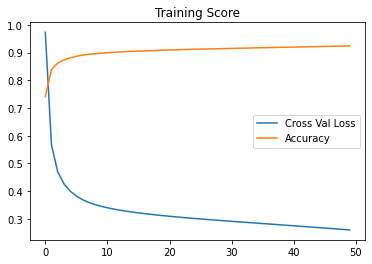

In [265]:
plt.plot(model.loss, label = 'Cross Val Loss')
plt.plot(model.accuracy, label = 'Accuracy')
plt.title('Training Score')
plt.legend()
plt.show()
# model.predict(X_test)

# Problem 8
Confirmation of misclassification

False classification count:  1898
Plot title shows (<Prediction>/<True Value>)


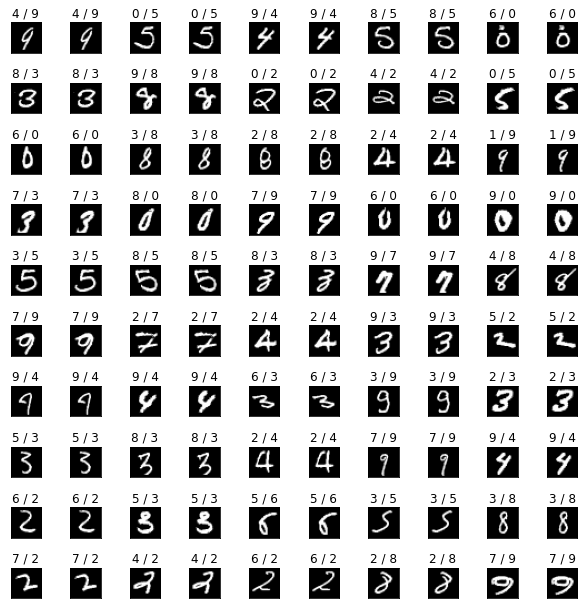

In [266]:
def show_misclassified(y_pred, y_val,X_val):
    """
    Display word classification results side by side. The display above the image is "estimated result / correct answer".
    Parameters:
    ----------
    y_pred : Estimated ndarray (n_samples,)
    y_val : Correct label of verification data (n_samples,)
    X_val : Verification data features (n_samples, n_features)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    size = 10
    num = size * size # How many to display

    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int)
    print('False classification count: ', len(false_list))
    print('Plot title shows (<Prediction>/<True Value>)')
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(size, size))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(size, size, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(np.argmax(y_pred[false_list[i]]),np.argmax(y_val[false_list[i]])))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')
show_misclassified(pred, y_val, X_val)